In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Harmful Algae Blooms in Bolinao (from HABhub) - Sheet1.csv")
print(df.shape)
print(df.info())
df.head()

(1929, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station_name      1929 non-null   object 
 1   embayment         1929 non-null   object 
 2   longitude         1929 non-null   float64
 3   latitude          1929 non-null   float64
 4   sample_date       1929 non-null   object 
 5   dissolved oxygen  1929 non-null   float64
 6   ph                1929 non-null   float64
 7   water temp        1929 non-null   float64
 8   time              1929 non-null   object 
 9   chlorophyll-a     1929 non-null   float64
dtypes: float64(6), object(4)
memory usage: 150.8+ KB
None


,station_name,embayment,longitude,latitude,sample_date,dissolved oxygen,ph,water temp,time,chlorophyll-a
0,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.5200,7.5755,28.8045,0:01:00,2.6136
1,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-1.0384,7.5566,28.7676,1:01:00,2.4442
2,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.9472,7.5881,28.7926,2:01:00,2.6257
3,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-1.1008,7.5566,28.7575,3:01:00,2.2264
4,CCMS_BML,Bolinao,119.9252,16.38712,2022-08-11,-0.9424,7.6007,28.8213,4:01:00,2.4079


### Split
Let us split the data first to prevent any leakage

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
df_train.nunique()

station_name           1
embayment              1
longitude              1
latitude               1
sample_date           92
dissolved oxygen     868
ph                   244
water temp          1480
time                  24
chlorophyll-a        689
dtype: int64

In [5]:
cont_vars = df_train.nunique() != 1
filtered_df = df_train[df_train.columns[cont_vars]]
filtered_df = filtered_df.rename(columns={"chlorophyll-a": "chl", 
                                         "dissolved oxygen": "dissolved_oxygen",
                                         "water temp": "water_temp"})
filtered_df

,sample_date,dissolved_oxygen,ph,water_temp,time,chl
1352,2022-10-12,-2.6848,6.9140,30.6774,6:01:00,4.6948
141,2022-08-17,0.3344,7.5692,29.8578,2:01:00,3.4848
2,2022-08-11,-0.9472,7.5881,28.7926,2:01:00,2.6257
1190,2022-10-01,-0.7552,6.8762,30.2540,10:01:00,2.9645
1803,2023-10-02,1.1163,-0.2700,32.4355,15:01:00,1.6214
...,...,...,...,...,...,...
1130,2022-09-28,-1.3408,6.9896,29.6580,22:01:00,2.9282
1294,2022-10-07,0.2960,6.8825,31.8933,19:01:00,7.3689
860,2022-09-17,-1.2544,6.8069,30.6729,13:01:00,4.5980
1459,2022-10-18,-2.6992,6.7754,29.7998,0:01:00,1.6335


In [6]:
filtered_df['sample_date'] = pd.to_datetime(filtered_df["sample_date"])
filtered_df['sample_date_int'] = filtered_df['sample_date'].astype("int64") / 10**11

filtered_df['time_hour'] = pd.to_datetime(filtered_df['time'], format="%H:%M:%S").dt.hour
filtered_df.drop(columns="time", inplace=True)

##### Note

* Converted `sample_date` to datetime format
* Added `sample_date_int` as a int varsion of the `sample_date` column
* Added `time_hour` to get only the Hour in time
* Removed the `time` column

Let us first do a simple Multiple Linear Regression to get a glimpse of everything

---

## Baseline Model

In [7]:
from statsmodels.formula.api import ols

formula = "chl ~ " + " + ".join([col for col in filtered_df.drop(columns="sample_date").columns  if col != "chl"])
lmlm = ols(formula, data=filtered_df)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    chl   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     103.2
Date:                Wed, 14 May 2025   Prob (F-statistic):           5.07e-94
Time:                        22:46:53   Log-Likelihood:                -4385.5
No. Observations:                1543   AIC:                             8783.
Df Residuals:                    1537   BIC:                             8815.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          718.6260     94.972      7.567      0.000     532.337     904.915
dissolved_oxygen     0.0799      0.036      2.226      0.026       0.009       0.150
ph                  -1.4007      0.278     -5.047      0.000      -1.945      -0.856
water_temp           1.9163      0.106     18.070      0.000       1.708       2.124
sample_date_int  -4.583e-05    5.6e-06     -8.184      0.000   -5.68e-05   -3.48e-05
time_hour            0.0729      0.016      4.573      0.000       0.042       0.104
==============================================================================
Omnibus:                     1067.235   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17136.045
Skew:                           3.060   Prob(JB):                         0.00
Kurtosis:                      18.135   Cond. No.                     1.49e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All are significant except the `dissolved_oxygen`. However, Adj R-Sq is low with 0.25. Let's look at the distributions to see if we can leverage any transformation. 

## EDA

#### Missing Values

In [8]:
filtered_df.isna().sum()

sample_date         0
dissolved_oxygen    0
ph                  0
water_temp          0
chl                 0
sample_date_int     0
time_hour           0
dtype: int64

#### Distribution

Text(0.5, 1.0, 'Distribution of Columns')

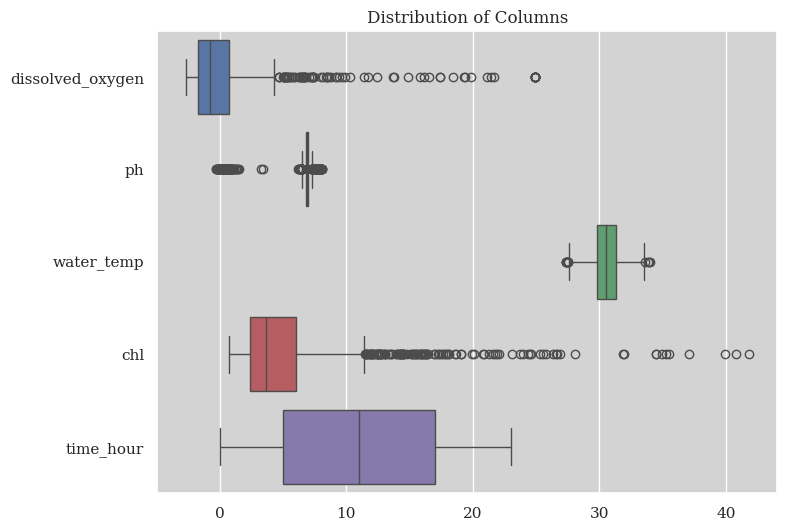

In [9]:
plt.figure(figsize=(8, 6))

sns.set_theme()
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['font.family'] = 'serif'

sns.boxplot(filtered_df.drop(columns=["sample_date", 'sample_date_int']), orient="h")
plt.title("Distribution of Columns")

Lots of outliers in all of columns with exception of `time_hour`.

Look at the `ph`see a huge jump from lower queartile to the outlier. This could indicate an error in measurement.

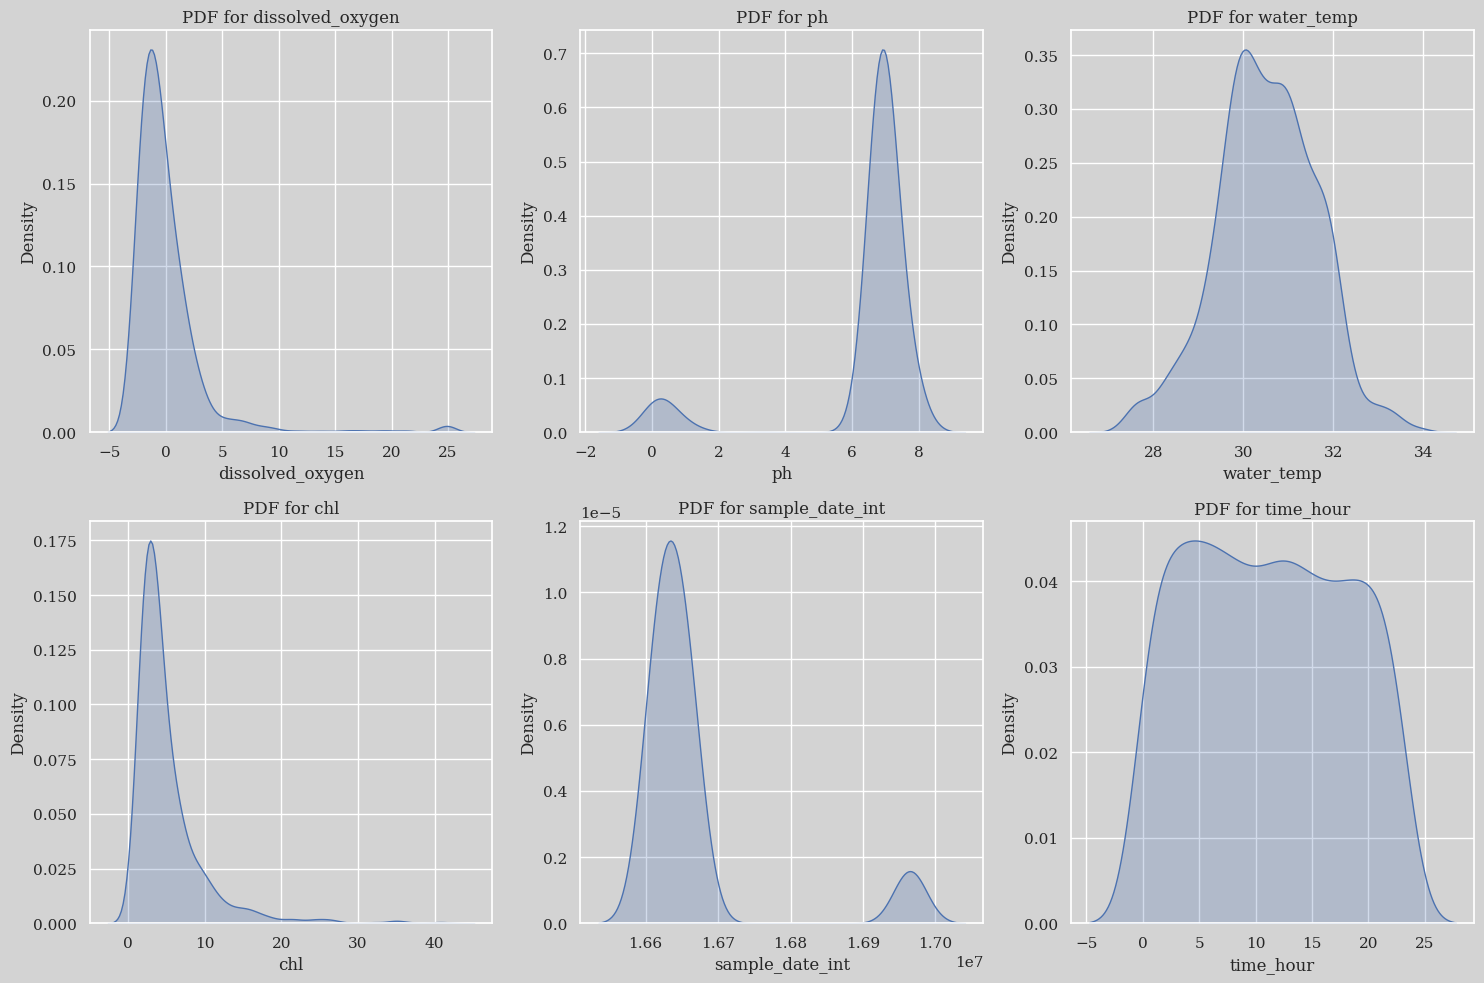

In [10]:

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

axes = ax.flatten()
cols = filtered_df.drop(columns=['sample_date']).columns.to_list()

for ind,col in enumerate(cols):
    sns.kdeplot(filtered_df[col], fill=True, ax=axes[ind])
    axes[ind].set_title(f"PDF for {col}")

plt.tight_layout()

Notice that both `sample_date` and `ph` are both significantly bimodal. This might mean an error in measurement was done on the same days.

Well it appears that all of our columns are skewed! With the exceptions of `water_temp` and `time_hour`.

This isn't usually an issue in a linear regression model but given that we also got significant amount of outliers for each of those skewed data, a transformation is in order. With transformation, we can reduce the outliers and normalize the data which is beneficial for our linear model.

Let's look at the domain for each column before proceeding.

In [11]:
filtered_df.agg(['min','max'])

,sample_date,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour
min,2022-08-11,-2.6992,-0.2700,27.3432,0.7018,16601760.0,0
max,2023-10-16,24.8880,8.0606,33.9583,41.8297,16974144.0,23


#### Before removal of outlirs in ph

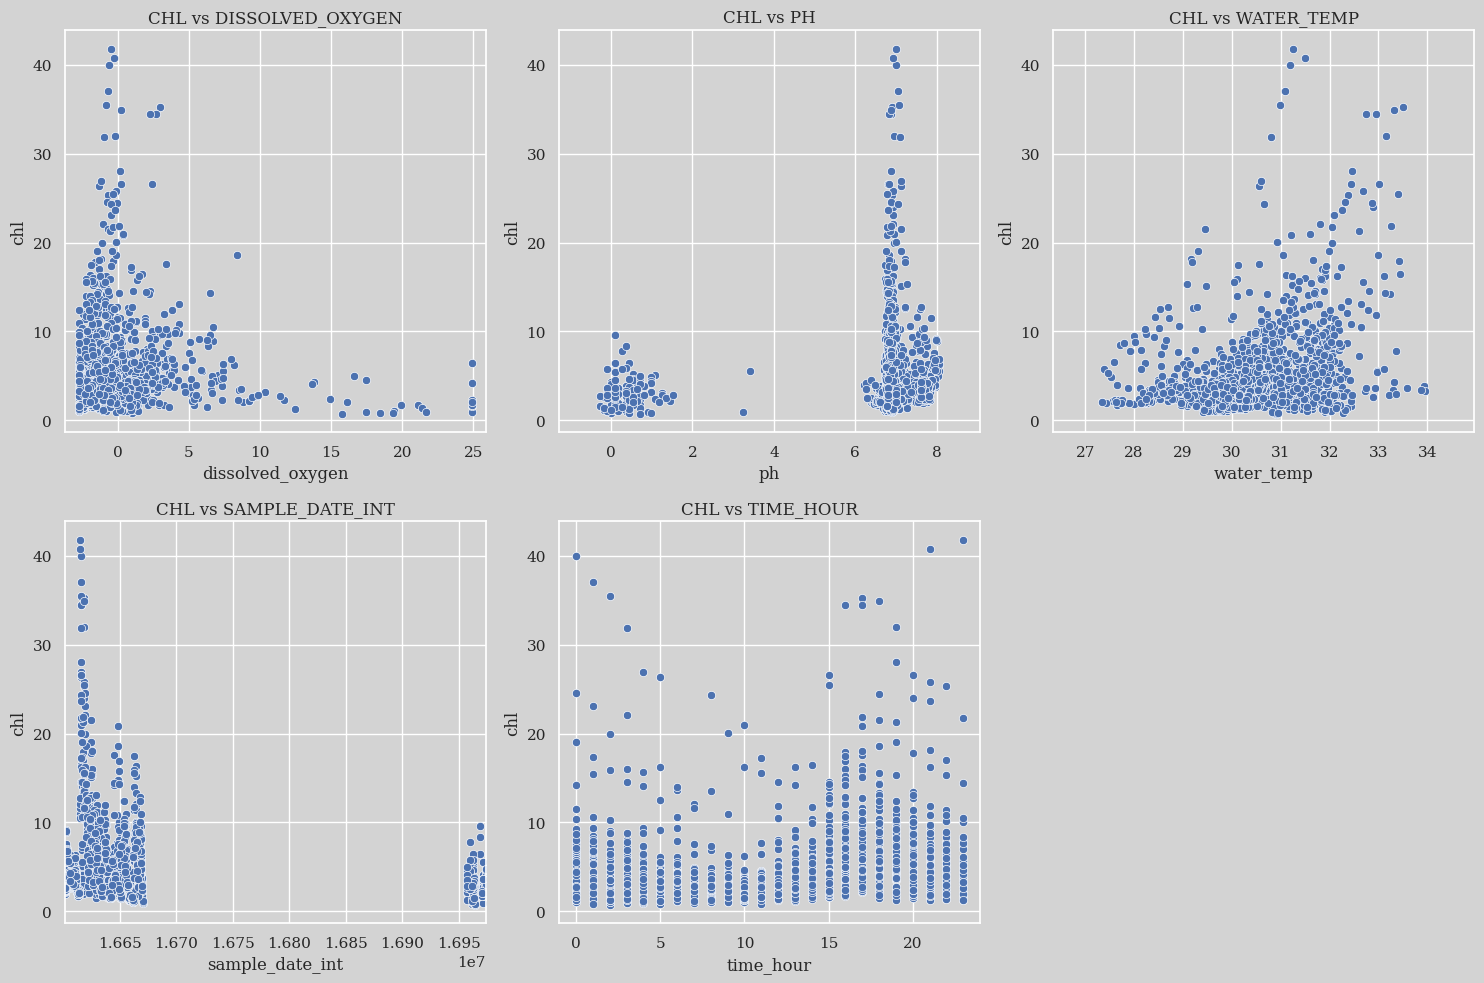

In [12]:
cols = filtered_df.drop(columns=['chl', 'sample_date']).columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
ax = ax.flatten()
for ind, col in enumerate(cols):
    sns.scatterplot(
        data=filtered_df,
        x=col,
        y="chl",
        ax=ax[ind]
    )
    ax[ind].set_title(f"CHL vs {col.upper()}")
    ax[ind].set_xlim(min(filtered_df[col]) -1 , max(filtered_df[col]) +1)
plt.delaxes(ax[-1])
plt.tight_layout()

In [13]:
filtered_df["ph"].describe()

count    1543.000000
mean        6.406682
std         1.921613
min        -0.270000
25%         6.813200
50%         6.895100
75%         6.995900
max         8.060600
Name: ph, dtype: float64

#### After removal of outliers

In [14]:
mask = filtered_df['ph'] > 4

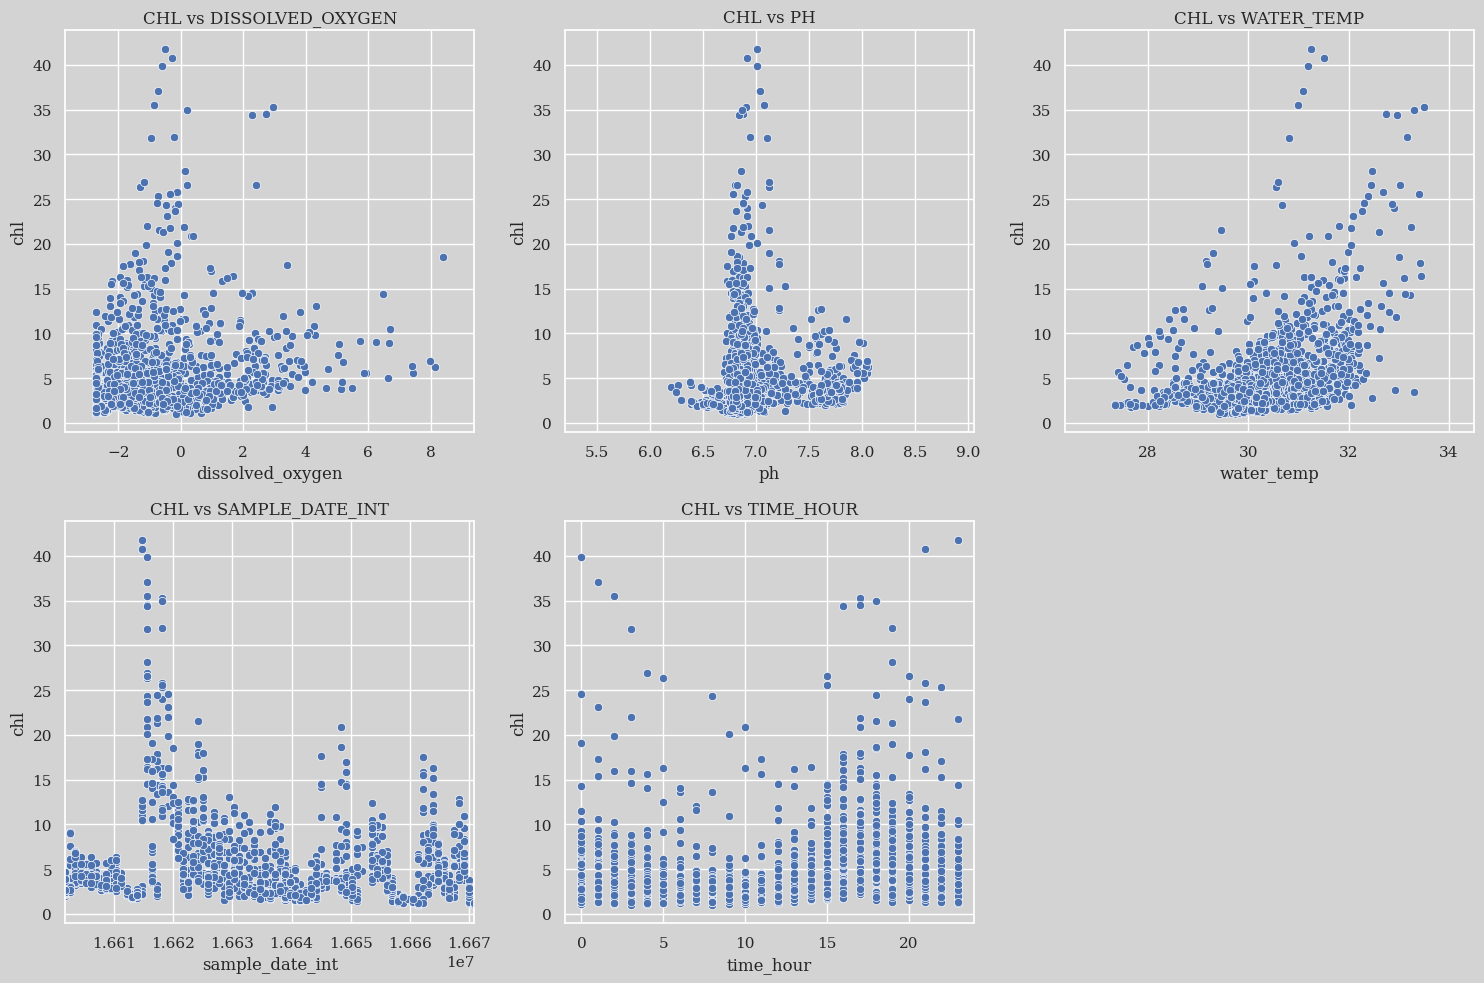

In [15]:
cols = filtered_df.drop(columns=['chl', 'sample_date']).columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
ax = ax.flatten()
for ind, col in enumerate(cols):
    sns.scatterplot(
        data=filtered_df[mask],
        x=col,
        y="chl",
        ax=ax[ind]
    )
    ax[ind].set_title(f"CHL vs {col.upper()}")
    ax[ind].set_xlim(min(filtered_df[mask][col]) -1 , max(filtered_df[mask][col]) +1)
plt.delaxes(ax[-1])
plt.tight_layout()

Text(0.5, 1.0, 'Distribution of Columns [After removal of outliers in PH]')

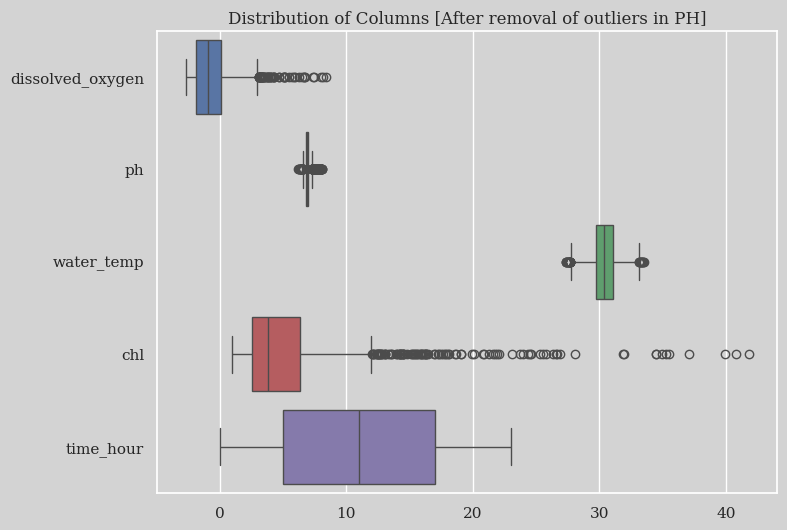

In [16]:
plt.figure(figsize=(8, 6))

sns.set_theme()
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['font.family'] = 'serif'

sns.boxplot(filtered_df[mask].drop(columns=["sample_date", 'sample_date_int']), orient="h")
plt.title("Distribution of Columns [After removal of outliers in PH]")

In [17]:
df_filter = filtered_df[mask].copy()

`chl` still has significant outliers. 

In [18]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")

pt.fit(filtered_df[mask][['chl']])

df_filter['chl_yeo'] =  pt.transform(filtered_df[mask][['chl']]).squeeze()

In [19]:
cols

Index(['dissolved_oxygen', 'ph', 'water_temp', 'sample_date_int', 'time_hour'], dtype='object')

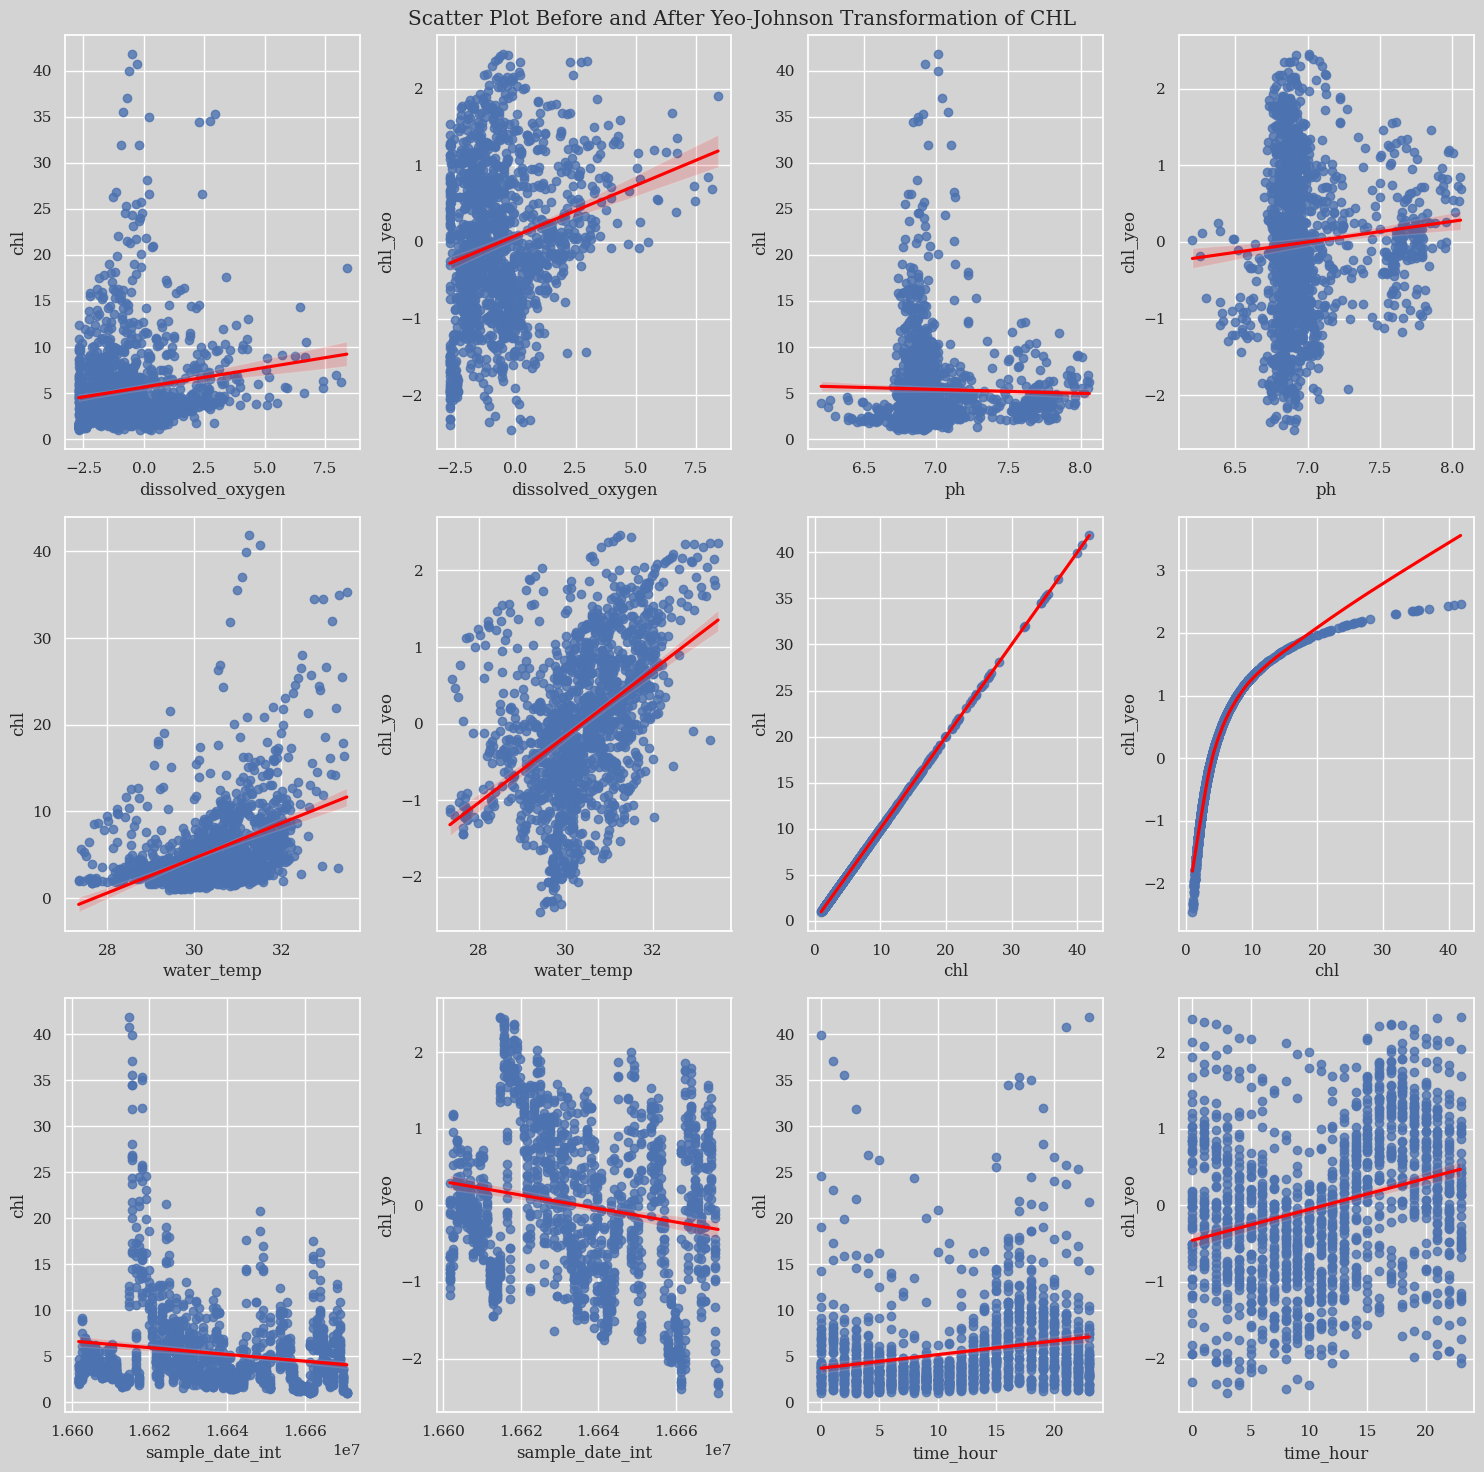

In [20]:
cols = df_filter.drop(columns=["chl_yeo", 'sample_date']).columns.to_list()
rows = int(np.ceil(len(cols)/2))

fig, axes = plt.subplots(ncols=4, nrows=rows, figsize=(15, 5*rows))

axes = axes.flatten()
for i in range(0, len(cols)*2, 2):
    sns.regplot(
        df_filter,
        x=cols[int(i/2)],
        y='chl',
        ax=axes[i],
        line_kws={"color" : "red"}
    )
    

    sns.regplot(
            df_filter,
            x=cols[int(i/2)],
            y='chl_yeo',
            ax=axes[i+1],
            line_kws={"color" : "red"}, 
            lowess=cols[int(i/2)] == "chl"
        )

fig.suptitle("Scatter Plot Before and After Yeo-Johnson Transformation of CHL");

plt.tight_layout()



#### PH

`ph` is a little tricky because the behaviour seem to be significantly different on different intervals. We could use splining in this case. 

In [21]:
formula = "chl_yeo ~ ph"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     9.309
Date:                Wed, 14 May 2025   Prob (F-statistic):            0.00232
Time:                        22:47:09   Log-Likelihood:                -1987.5
No. Observations:                1404   AIC:                             3979.
Df Residuals:                    1402   BIC:                             3990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8849      0.618     -3.048      0.002      -3.098      -0.672
ph             0.2692      0.088      3.051      0.002       0.096       0.442
==============================================================================
Omnibus:                       33.963   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.131
Skew:                           0.129   Prob(JB):                     4.25e-05
Kurtosis:                       2.474   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is the best parameter I could get.

In [22]:
formula = "chl_yeo ~ bs(ph, df=5)"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     7.568
Date:                Wed, 14 May 2025   Prob (F-statistic):           5.03e-07
Time:                        22:47:09   Log-Likelihood:                -1973.4
No. Observations:                1404   AIC:                             3959.
Df Residuals:                    1398   BIC:                             3990.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5294      0.620      0.854      0.393      -0.686       1.745
bs(ph, df=5)[0]    -2.9260      0.983     -2.978      0.003      -4.853      -0.999
bs(ph, df=5)[1]    -0.2219      0.597     -0.372      0.710      -1.393       0.949
bs(ph, df=5)[2]    -0.8548      0.690     -1.239      0.216      -2.209       0.499
bs(ph, df=5)[3]    -0.4668      0.661     -0.706      0.480      -1.763       0.829
bs(ph, df=5)[4]     0.0120      0.698      0.017      0.986      -1.357       1.381
==============================================================================
Omnibus:                       21.456   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.460
Skew:                           0.075   Prob(JB):                      0.00119
Kurtosis:                       2.544   Cond. No.                         74.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Sample Date Int

Looking at the scatter plot of `sample_date_int`, it looks too random to give a significant slope.

In [23]:
formula = "chl_yeo ~ sample_date_int"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     45.69
Date:                Wed, 14 May 2025   Prob (F-statistic):           2.02e-11
Time:                        22:47:09   Log-Likelihood:                -1969.7
No. Observations:                1404   AIC:                             3943.
Df Residuals:                    1402   BIC:                             3954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         146.7189     21.705      6.760      0.000     104.140     189.297
sample_date_int  -8.82e-06    1.3e-06     -6.760      0.000   -1.14e-05   -6.26e-06
==============================================================================
Omnibus:                      120.488   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.977
Skew:                           0.155   Prob(JB):                     4.65e-10
Kurtosis:                       2.201   Cond. No.                     1.37e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
formula = "chl_yeo ~ sample_date_int + np.power(sample_date_int, 2) + np.power(sample_date_int, 3) +  np.power(sample_date_int, 4)"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     45.81
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.91e-11
Time:                        22:47:09   Log-Likelihood:                -1969.6
No. Observations:                1404   AIC:                             3943.
Df Residuals:                    1402   BIC:                             3954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     2.772e-41   4.09e-42      6.768      0.000    1.97e-41    3.57e-41
sample_date_int              -2.388e-28   3.53e-29     -6.768      0.000   -3.08e-28    -1.7e-28
np.power(sample_date_int, 2)  3.835e-27   5.67e-28      6.768      0.000    2.72e-27    4.95e-27
np.power(sample_date_int, 3)   3.19e-20   4.71e-21      6.768      0.000    2.27e-20    4.11e-20
np.power(sample_date_int, 4) -1.918e-27   2.83e-28     -6.769      0.000   -2.47e-27   -1.36e-27
==============================================================================
Omnibus:                      120.667   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.015
Skew:                           0.155   Prob(JB):                     4.56e-10
Kurtosis:                       2.201   Cond. No.                     4.44e+40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.17e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Yep, no difference.

#### Water Tempt

In [25]:
formula = "chl_yeo ~ water_temp"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     376.7
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.62e-74
Time:                        22:47:09   Log-Likelihood:                -1825.1
No. Observations:                1404   AIC:                             3654.
Df Residuals:                    1402   BIC:                             3665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.1802      0.679    -19.398      0.000     -14.513     -11.847
water_temp     0.4338      0.022     19.409      0.000       0.390       0.478
==============================================================================
Omnibus:                        1.772   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.412   Jarque-Bera (JB):                1.741
Skew:                           0.038   Prob(JB):                        0.419
Kurtosis:                       2.845   Cond. No.                         872.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
temp_trans = PowerTransformer()
temp_trans.fit(df_filter[['water_temp']])

df_filter['water_temp_yeo'] =temp_trans.transform(df_filter[['water_temp']])

In [27]:
formula = "chl_yeo ~ water_temp_yeo"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     388.3
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.69e-76
Time:                        22:47:09   Log-Likelihood:                -1820.6
No. Observations:                1404   AIC:                             3645.
Df Residuals:                    1402   BIC:                             3656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.984e-16      0.024  -1.26e-14      1.000      -0.046       0.046
water_temp_yeo     0.4657      0.024     19.706      0.000       0.419       0.512
==============================================================================
Omnibus:                        1.655   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.437   Jarque-Bera (JB):                1.647
Skew:                           0.040   Prob(JB):                        0.439
Kurtosis:                       2.852   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
formula = "chl_yeo ~ water_temp + np.power(water_temp, 2) + np.power(water_temp, 3) + np.power(water_temp, 4) "
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     132.4
Date:                Wed, 14 May 2025   Prob (F-statistic):           5.91e-96
Time:                        22:47:09   Log-Likelihood:                -1766.9
No. Observations:                1404   AIC:                             3544.
Df Residuals:                    1399   BIC:                             3570.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1.397e+04   4396.776     -3.177      0.002   -2.26e+04   -5343.893
water_temp               1870.2356    580.260      3.223      0.001     731.963    3008.508
np.power(water_temp, 2)   -93.6770     28.688     -3.265      0.001    -149.954     -37.400
np.power(water_temp, 3)     2.0801      0.630      3.303      0.001       0.845       3.315
np.power(water_temp, 4)    -0.0173      0.005     -3.335      0.001      -0.027      -0.007
==============================================================================
Omnibus:                        5.346   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                4.729
Skew:                           0.079   Prob(JB):                       0.0940
Kurtosis:                       2.764   Cond. No.                     1.69e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Log transform makes the predictor worse. Yeo-Johnson makes it better. Bit increases it best.

#### Dissolved Oxygen

In [29]:
formula = "chl_yeo ~ dissolved_oxygen"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     75.63
Date:                Wed, 14 May 2025   Prob (F-statistic):           9.38e-18
Time:                        22:47:09   Log-Likelihood:                -1955.3
No. Observations:                1404   AIC:                             3915.
Df Residuals:                    1402   BIC:                             3925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0786      0.028      2.854      0.004       0.025       0.133
dissolved_oxygen     0.1320      0.015      8.697      0.000       0.102       0.162
==============================================================================
Omnibus:                       40.410   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.011
Skew:                           0.183   Prob(JB):                     3.71e-06
Kurtosis:                       2.458   Cond. No.                         2.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So we can't do log transformation because `dissolved_oxygen` and `ph` has negative values.

Let's try "Yeo-Jhonson" since it can handle negative values.

In [30]:
from sklearn.preprocessing import PowerTransformer

temp_trans = PowerTransformer()
temp_trans.fit(df_filter[['dissolved_oxygen']])

df_filter['dissolved_oxygen_yeo'] = temp_trans.transform(df_filter[['dissolved_oxygen']])

In [31]:
formula = "chl_yeo ~ dissolved_oxygen_yeo"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     69.67
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.66e-16
Time:                        22:47:09   Log-Likelihood:                -1958.1
No. Observations:                1404   AIC:                             3920.
Df Residuals:                    1402   BIC:                             3931.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -2.984e-16      0.026  -1.14e-14      1.000      -0.051       0.051
dissolved_oxygen_yeo     0.2176      0.026      8.347      0.000       0.166       0.269
==============================================================================
Omnibus:                       48.134   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.584
Skew:                           0.163   Prob(JB):                     1.69e-06
Kurtosis:                       2.410   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Dissolved Oxygen With and Without Yeo-Johnson')

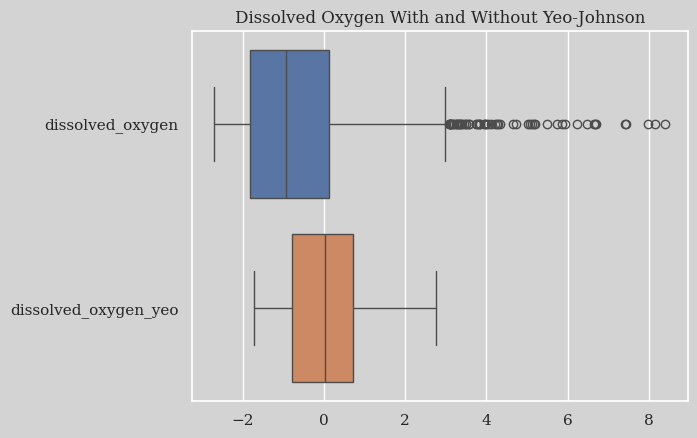

In [32]:
sns.boxplot(
    df_filter[['dissolved_oxygen', 'dissolved_oxygen_yeo']],
    orient="h"
)

plt.title("Dissolved Oxygen With and Without Yeo-Johnson")

Although untransformed predictor results to more R-Sq, I think we should still use the transformed version because (1) the outliers was controlled that will be helpful in the context of multiple linear regression and (2) the difference isn't that much to begin with. 

Well, to be fair, `dissolved_oxygen` by itself isn't a good predictor.

#### Time Hour

Looking at the scatter plot of Time Hour, we can fit a polynomial regression in it.

In [33]:
formula = "chl_yeo ~ time_hour"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     116.6
Date:                Wed, 14 May 2025   Prob (F-statistic):           3.58e-26
Time:                        22:47:09   Log-Likelihood:                -1936.1
No. Observations:                1404   AIC:                             3876.
Df Residuals:                    1402   BIC:                             3887.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4571      0.049     -9.235      0.000      -0.554      -0.360
time_hour      0.0403      0.004     10.800      0.000       0.033       0.048
==============================================================================
Omnibus:                        7.930   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                6.263
Skew:                           0.064   Prob(JB):                       0.0436
Kurtosis:                       2.699   Cond. No.                         25.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
formula = "chl_yeo ~ time_hour + np.power(time_hour, 2) + np.power(time_hour, 3) + np.power(time_hour, 4)"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     87.96
Date:                Wed, 14 May 2025   Prob (F-statistic):           9.94e-67
Time:                        22:47:09   Log-Likelihood:                -1834.7
No. Observations:                1404   AIC:                             3679.
Df Residuals:                    1399   BIC:                             3706.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1101      0.095      1.161      0.246      -0.076       0.296
time_hour                 -0.0710      0.059     -1.195      0.232      -0.188       0.046
np.power(time_hour, 2)    -0.0219      0.011     -2.011      0.045      -0.043      -0.001
np.power(time_hour, 3)     0.0033      0.001      4.557      0.000       0.002       0.005
np.power(time_hour, 4) -9.715e-05   1.57e-05     -6.204      0.000      -0.000   -6.64e-05
==============================================================================
Omnibus:                        1.368   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                1.277
Skew:                          -0.034   Prob(JB):                        0.528
Kurtosis:                       3.131   Cond. No.                     4.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Final Model (?)

In [35]:
formula = "chl_yeo ~ dissolved_oxygen + water_temp + time_hour + ph"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     138.3
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.13e-99
Time:                        22:47:10   Log-Likelihood:                -1758.2
No. Observations:                1404   AIC:                             3526.
Df Residuals:                    1399   BIC:                             3553.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -16.6556      1.069    -15.579      0.000     -18.753     -14.558
dissolved_oxygen     0.0348      0.016      2.217      0.027       0.004       0.066
water_temp           0.4190      0.023     18.257      0.000       0.374       0.464
time_hour            0.0276      0.003      8.121      0.000       0.021       0.034
ph                   0.5186      0.090      5.791      0.000       0.343       0.694
==============================================================================
Omnibus:                        8.464   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.068
Skew:                           0.098   Prob(JB):                       0.0292
Kurtosis:                       2.713   Cond. No.                     1.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
formula = "chl_yeo ~ dissolved_oxygen_yeo +  water_temp + np.power(water_temp, 2) + np.power(water_temp, 3) + np.power(water_temp, 4) + time_hour + np.power(time_hour, 2) + np.power(time_hour, 3) + np.power(time_hour, 4) + bs(ph, df=5) + sample_date_int"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     77.67
Date:                Wed, 14 May 2025   Prob (F-statistic):          2.12e-171
Time:                        22:47:10   Log-Likelihood:                -1564.4
No. Observations:                1404   AIC:                             3161.
Df Residuals:                    1388   BIC:                             3245.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1801.2744   3900.970     -0.462      0.644   -9453.708    5851.159
dissolved_oxygen_yeo        0.0671      0.024      2.784      0.005       0.020       0.114
water_temp                288.7986    514.424      0.561      0.575    -720.334    1297.931
np.power(water_temp, 2)   -16.0352     25.429     -0.631      0.528     -65.919      33.849
np.power(water_temp, 3)     0.3890      0.558      0.697      0.486      -0.706       1.484
np.power(water_temp, 4)    -0.0035      0.005     -0.760      0.448      -0.012       0.006
time_hour                  -0.0154      0.050     -0.307      0.759      -0.114       0.083
np.power(time_hour, 2)     -0.0277      0.009     -3.019      0.003      -0.046      -0.010
np.power(time_hour, 3)      0.0033      0.001      5.510      0.000       0.002       0.005
np.power(time_hour, 4)  -9.233e-05   1.31e-05     -7.072      0.000      -0.000   -6.67e-05
bs(ph, df=5)[0]            -1.1854      0.757     -1.567      0.117      -2.670       0.299
bs(ph, df=5)[1]            -0.6694      0.454     -1.476      0.140      -1.559       0.220
bs(ph, df=5)[2]             0.3465      0.525      0.660      0.509      -0.683       1.376
bs(ph, df=5)[3]             0.2936      0.500      0.588      0.557      -0.686       1.274
bs(ph, df=5)[4]            -0.9504      0.530     -1.795      0.073      -1.989       0.088
sample_date_int         -6.605e-06   1.38e-06     -4.778      0.000   -9.32e-06   -3.89e-06
==============================================================================
Omnibus:                       10.966   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.100
Skew:                           0.163   Prob(JB):                      0.00641
Kurtosis:                       2.743   Cond. No.                     3.31e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I think its not ideal to add sample_date_int because we wouldn't have any data for future. We can't generalize this predictor.

In [37]:
formula = "chl_yeo ~ dissolved_oxygen_yeo +  water_temp + np.power(water_temp, 2) + np.power(water_temp, 3) + np.power(water_temp, 4) + time_hour + np.power(time_hour, 2) + np.power(time_hour, 3) + np.power(time_hour, 4) + bs(ph, df=5)"
lmlm = ols(formula, data=df_filter)
results = lmlm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                chl_yeo   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     80.32
Date:                Wed, 14 May 2025   Prob (F-statistic):          1.69e-167
Time:                        22:47:10   Log-Likelihood:                -1575.8
No. Observations:                1404   AIC:                             3182.
Df Residuals:                    1389   BIC:                             3260.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -3906.0147   3906.354     -1.000      0.318   -1.16e+04    3756.976
dissolved_oxygen_yeo        0.0992      0.023      4.254      0.000       0.053       0.145
water_temp                550.7507    515.497      1.068      0.286    -460.487    1561.988
np.power(water_temp, 2)   -28.8996     25.484     -1.134      0.257     -78.891      21.092
np.power(water_temp, 3)     0.6690      0.559      1.196      0.232      -0.428       1.766
np.power(water_temp, 4)    -0.0058      0.005     -1.254      0.210      -0.015       0.003
time_hour                  -0.0144      0.051     -0.284      0.776      -0.114       0.085
np.power(time_hour, 2)     -0.0275      0.009     -2.972      0.003      -0.046      -0.009
np.power(time_hour, 3)      0.0033      0.001      5.425      0.000       0.002       0.005
np.power(time_hour, 4)  -9.166e-05   1.32e-05     -6.966      0.000      -0.000   -6.58e-05
bs(ph, df=5)[0]            -0.8757      0.760     -1.153      0.249      -2.366       0.615
bs(ph, df=5)[1]            -0.9880      0.452     -2.185      0.029      -1.875      -0.101
bs(ph, df=5)[2]             0.4236      0.529      0.801      0.423      -0.613       1.461
bs(ph, df=5)[3]             0.2581      0.503      0.513      0.608      -0.729       1.246
bs(ph, df=5)[4]            -0.9038      0.534     -1.694      0.091      -1.951       0.143
==============================================================================
Omnibus:                        5.088   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.816
Skew:                           0.104   Prob(JB):                       0.0900
Kurtosis:                       2.801   Cond. No.                     1.72e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model Selection

We shall conduct exhaustive search to select the final model.

In [38]:
from itertools import combinations

potential_predictors = [
    "dissolved_oxygen_yeo",
    "water_temp",
    "np.power(water_temp, 2)",
    "np.power(water_temp, 3)",
    "np.power(water_temp, 4)",
    "time_hour",
    "np.power(time_hour, 2)",
    "np.power(time_hour, 3)",
    "np.power(time_hour, 4)",
    "bs(ph, df=5)"
]

results = []



for r in range(1, len(potential_predictors)+ 1):
    comb = combinations(potential_predictors, r)
    for com in comb:
        formula = "chl_yeo ~ " + " + ".join(com)
        model_tempt = ols(formula, data=df_filter)
        model_tempt = model_tempt.fit()

        result = {
            "predictors" : com,
            "r" : r,
            "RSS" : model_tempt.ssr,
            "RSE" : np.sqrt(model_tempt.scale),
            "Adj_RSq" : model_tempt.rsquared_adj,
            "AIC" : model_tempt.aic,
            "BIC" : model_tempt.bic
        }

        results.append(result)

In [39]:
exhaustive_search = pd.DataFrame(results)
exhaustive_search.shape

(1023, 7)

In [40]:
sorted_search = exhaustive_search.sort_values(by="Adj_RSq", ascending=False).reset_index(drop=True).head(20)
sorted_search

,predictors,r,RSS,RSE,Adj_RSq,AIC,BIC
0,"(dissolved_oxygen_yeo, water_temp, np.power(wa...",9,775.917161,0.747137,0.442184,3179.758512,3253.217640
1,"(dissolved_oxygen_yeo, np.power(water_temp, 2)...",8,776.576343,0.747186,0.442111,3178.950776,3247.162824
2,"(dissolved_oxygen_yeo, water_temp, np.power(wa...",8,776.658516,0.747225,0.442052,3179.099333,3247.311380
3,"(dissolved_oxygen_yeo, water_temp, np.power(wa...",8,776.740606,0.747265,0.441993,3179.247722,3247.459770
4,"(dissolved_oxygen_yeo, water_temp, np.power(wa...",8,776.820611,0.747303,0.441936,3179.392328,3247.604375
5,"(dissolved_oxygen_yeo, water_temp, np.power(wa...",10,775.872057,0.747384,0.441815,3181.676896,3260.383104
6,"(dissolved_oxygen_yeo, np.power(water_temp, 2)...",9,776.509652,0.747422,0.441758,3180.830199,3254.289327
7,"(dissolved_oxygen_yeo, water_temp, np.power(wa...",9,776.590393,0.747461,0.441700,3180.976178,3254.435306
8,"(dissolved_oxygen_yeo, water_temp, np.power(wa...",9,776.671119,0.747500,0.441642,3181.122114,3254.581242
9,"(dissolved_oxygen_yeo, water_temp, np.power(wa...",9,776.749853,0.747538,0.441585,3181.264436,3254.723564


NameError: name 'sasad' is not defined

In [ ]:
sorted_search.iloc[1, 0]

('dissolved_oxygen_yeo',
 'np.power(water_temp, 2)',
 'np.power(water_temp, 3)',
 'np.power(water_temp, 4)',
 'np.power(time_hour, 2)',
 'np.power(time_hour, 3)',
 'np.power(time_hour, 4)',
 'bs(ph, df=5)')

Let's choose this one since its simpler and doesn't fall far from the other who has more.

In [ ]:
def wrangle(data, tranformers={}):
    df_data = data.copy()
    
    cont_vars = df_data.nunique() != 1
    df_data = df_data[df_data.columns[cont_vars]]
    df_data = df_data.rename(columns={"chlorophyll-a": "chl", 
                                            "dissolved oxygen": "dissolved_oxygen",
                                            "water temp": "water_temp"})

    # convert sample date to datetime
    df_data['sample_date'] = pd.to_datetime(df_data["sample_date"])
    df_data['sample_date_int'] = df_data['sample_date'].astype("int64") / 10**11

    # convert time to time_hour
    df_data['time_hour'] = pd.to_datetime(df_data['time'], format="%H:%M:%S").dt.hour
    df_data.drop(columns="time", inplace=True)

    # remove outliers in ph
    mask = df_data['ph'] > 4

    yeos = ['chl', 'dissolved_oxygen']

    df_no_outliers = df_data[mask].copy()

    train_mode = len(tranformers) == 0

    # yeo transformation
    for col in yeos:
        if train_mode:
            print("Train Mode")
            temp_trans = PowerTransformer()
            temp_trans.fit(df_no_outliers[[col]])
            df_no_outliers[f'{col}_yeo'] = temp_trans.transform(df_no_outliers[[col]])
            tranformers[f'{col}_yeo'] = temp_trans
        else:
            print("Test Mode")
            df_no_outliers[f'{col}_yeo'] = tranformers[f'{col}_yeo'].transform(df_no_outliers[[col]])
    
    return df_no_outliers, tranformers

In [ ]:
df_train_clean, tranformers = wrangle(df_train)
df_train_clean

Train Mode
Train Mode


,sample_date,dissolved_oxygen,ph,water_temp,chl,sample_date_int,time_hour,chl_yeo,dissolved_oxygen_yeo
1352,2022-10-12,-2.6848,6.9140,30.6774,4.6948,16655328.0,6,0.293678,-1.708548
141,2022-08-17,0.3344,7.5692,29.8578,3.4848,16606944.0,2,-0.183613,0.827160
2,2022-08-11,-0.9472,7.5881,28.7926,2.6257,16601760.0,2,-0.670764,0.006788
1190,2022-10-01,-0.7552,6.8762,30.2540,2.9645,16645824.0,10,-0.458439,0.157149
1116,2022-09-28,-0.8416,7.0274,28.9762,1.7908,16643232.0,8,-1.363309,0.090571
...,...,...,...,...,...,...,...,...,...
1130,2022-09-28,-1.3408,6.9896,29.6580,2.9282,16643232.0,22,-0.479775,-0.327853
1294,2022-10-07,0.2960,6.8825,31.8933,7.3689,16651008.0,19,0.931268,0.808907
860,2022-09-17,-1.2544,6.8069,30.6729,4.5980,16633728.0,13,0.261675,-0.251461
1459,2022-10-18,-2.6992,6.7754,29.7998,1.6335,16660512.0,0,-1.532279,-1.725164


In [ ]:
def detect_outliers(data, mult=1.5, normalized=True):
    '''Count the outliers using iqr'''
    lower, upper = data.quantile([0.25,0.75])

    iqr = upper - lower

    lower_bound, upper_bound = lower - iqr*mult, upper + iqr*mult

    outliers = len(data) - (data.between(lower_bound, upper_bound)).sum()
    if not normalized:
        return outliers
    else:
        return outliers / len(data)

In [ ]:
df_train_clean.apply(detect_outliers, axis=0) 

sample_date             0.000000
dissolved_oxygen        0.040598
ph                      0.159544
water_temp              0.020655
chl                     0.074074
sample_date_int         0.000000
time_hour               0.000000
chl_yeo                 0.000000
dissolved_oxygen_yeo    0.000000
water_temp_yeo          0.013533
dtype: float64

`ph` is the only one left with outliers (we didn't use `chl` and `water_temp_yeo`). 

#### Correlation

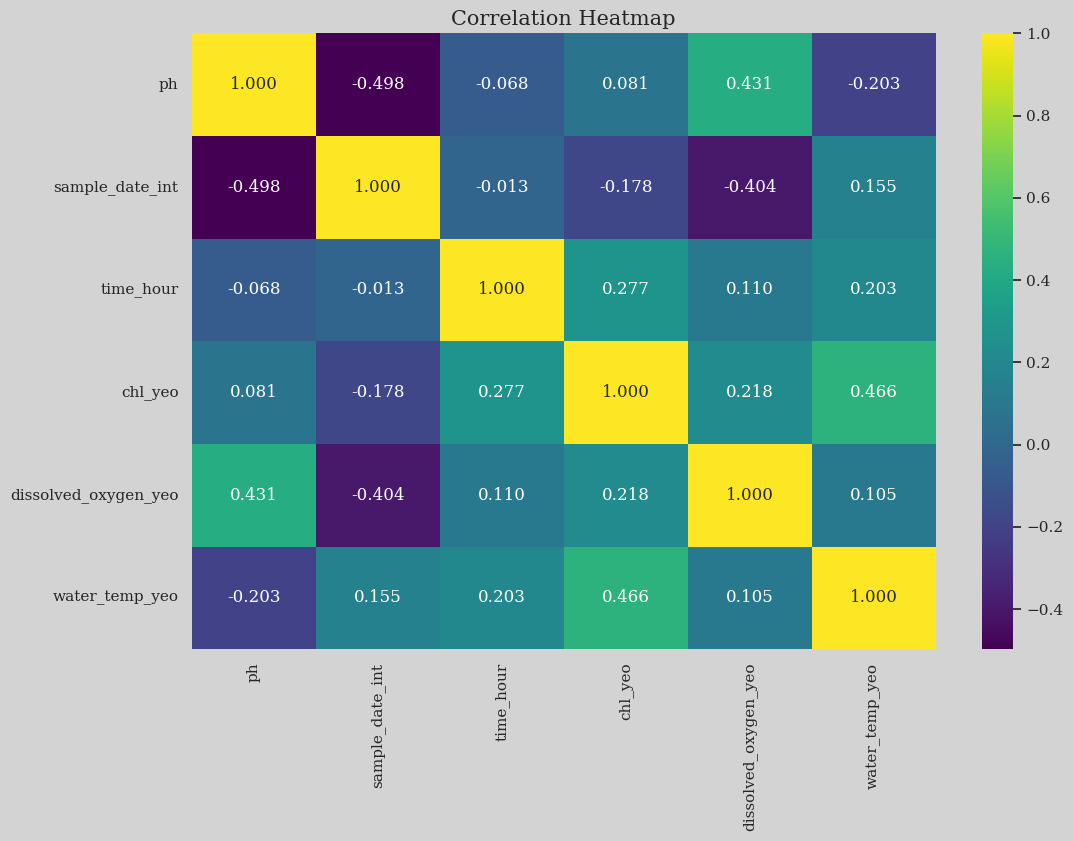

In [ ]:
corr = df_train_clean.drop(columns=['chl', 'dissolved_oxygen', 'sample_date', 'water_temp']).corr()
plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".3f",
    cmap='viridis'
)

plt.title("Correlation Heatmap", size=15);

---

# Final Model

In [ ]:
data = df_train_clean['water_temp_yeo']

mult = 1.5

lower, upper = data.quantile([0.25,0.75])

iqr = upper - lower

lower_bound, upper_bound = lower - iqr*mult, upper + iqr*mult

mask = data.between(lower_bound, upper_bound)

In [ ]:
min_ph = min(df_train_clean['ph'].min(), df_test_clean['ph'].min())
max_ph = max(df_train_clean['ph'].max(), df_test_clean['ph'].max())

# If you only have train data available right now, use its min/max, but be aware
# predictions on test data outside this range will still rely on the boundaries you set here.
# min_ph = df_train_clean['ph'].min()
# max_ph = df_train_clean['ph'].max()


# Modify the 'cols' tuple to include lower_bound and upper_bound in the bs() call
# Use an f-string to embed the min_ph and max_ph variables
# cols = ('water_temp_yeo',
#         'np.power(time_hour, 2)',
#         'np.power(time_hour, 3)',
#         'np.power(time_hour, 4)',
#         f'bs(ph, df=5, lower_bound={min_ph}, upper_bound={max_ph})')

cols = ('dissolved_oxygen_yeo',
 'np.power(water_temp, 2)',
 'np.power(water_temp, 3)',
 'np.power(water_temp, 4)',
 'np.power(time_hour, 2)',
 'np.power(time_hour, 3)',
 'np.power(time_hour, 4)',
 f'bs(ph, df=5, lower_bound={min_ph}, upper_bound={max_ph})')

formula = "chl_yeo ~ " + " + ".join(cols)
model = ols(formula, data=df_train_clean)
model = model.fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
===========================================================================================================
Model:                             OLS                           Adj. R-squared:                  0.442    
Dependent Variable:                chl_yeo                       AIC:                             3178.9508
Date:                              2025-05-07 18:53              BIC:                             3247.1628
No. Observations:                  1404                          Log-Likelihood:                  -1576.5  
Df Model:                          12                            F-statistic:                     93.65    
Df Residuals:                      1391                          Prob (F-statistic):              3.36e-169
R-squared:                         0.447                         Scale:                           0.55829  
-----------------------------------------------------------------------------------------------------------
                                                         Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------------------------------------------------
Intercept                                               267.1741  50.7502   5.2645 0.0000 167.6189 366.7294
dissolved_oxygen_yeo                                      0.0984   0.0233   4.2298 0.0000   0.0527   0.1440
np.power(water_temp, 2)                                  -1.6745   0.3312  -5.0555 0.0000  -2.3243  -1.0248
np.power(water_temp, 3)                                   0.0716   0.0146   4.9205 0.0000   0.0431   0.1001
np.power(water_temp, 4)                                  -0.0009   0.0002  -4.7626 0.0000  -0.0012  -0.0005
np.power(time_hour, 2)                                   -0.0302   0.0025 -11.9024 0.0000  -0.0351  -0.0252
np.power(time_hour, 3)                                    0.0035   0.0003  13.1939 0.0000   0.0030   0.0040
np.power(time_hour, 4)                                   -0.0001   0.0000 -13.4634 0.0000  -0.0001  -0.0001
bs(ph, df=5, lower_bound=6.1706, upper_bound=8.0606)[0]  -0.9797   0.9090  -1.0778 0.2813  -2.7628   0.8034
bs(ph, df=5, lower_bound=6.1706, upper_bound=8.0606)[1]  -1.1262   0.5492  -2.0508 0.0405  -2.2035  -0.0489
bs(ph, df=5, lower_bound=6.1706, upper_bound=8.0606)[2]   0.3157   0.6353   0.4970 0.6193  -0.9305   1.5619
bs(ph, df=5, lower_bound=6.1706, upper_bound=8.0606)[3]   0.1546   0.5947   0.2599 0.7949  -1.0121   1.3212
bs(ph, df=5, lower_bound=6.1706, upper_bound=8.0606)[4]  -1.0162   0.6308  -1.6110 0.1074  -2.2537   0.2212
-----------------------------------------------------------------------------------------------------------
Omnibus:                           5.076                    Durbin-Watson:                       1.999     
Prob(Omnibus):                     0.079                    Jarque-Bera (JB):                    4.779     
Skew:                              0.101                    Prob(JB):                            0.092     
Kurtosis:                          2.798                    Condition No.:                       2211978114
===========================================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+09. This might indicate                that there are strong
multicollinearity or other numerical                problems.
"""

---
## Assumptions

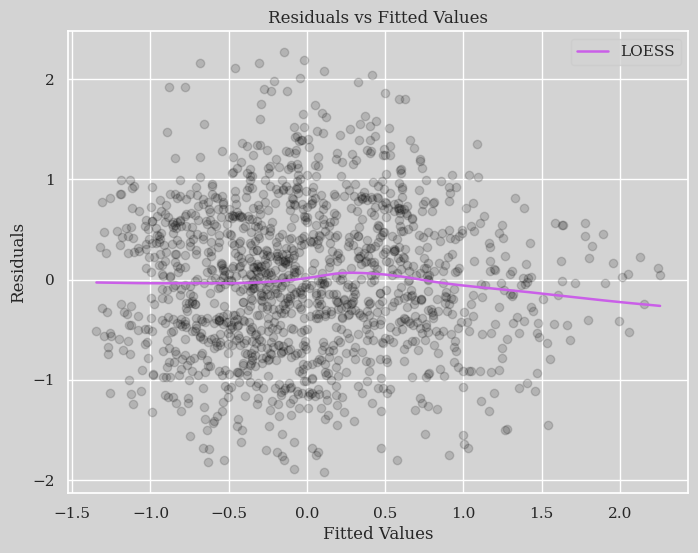

In [ ]:
plt.figure(figsize=(8, 6))

sns.regplot(x=model.predict(), 
            y=model.resid, 
            scatter_kws={'alpha':0.15, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(model.resid.to_frame())
standardized_resid = scaler.transform(model.resid.to_frame()).squeeze()
standardized_resid_sorted = np.sort(standardized_resid)

normal_theo = np.sort(np.random.normal(0, 1, len(standardized_resid)));

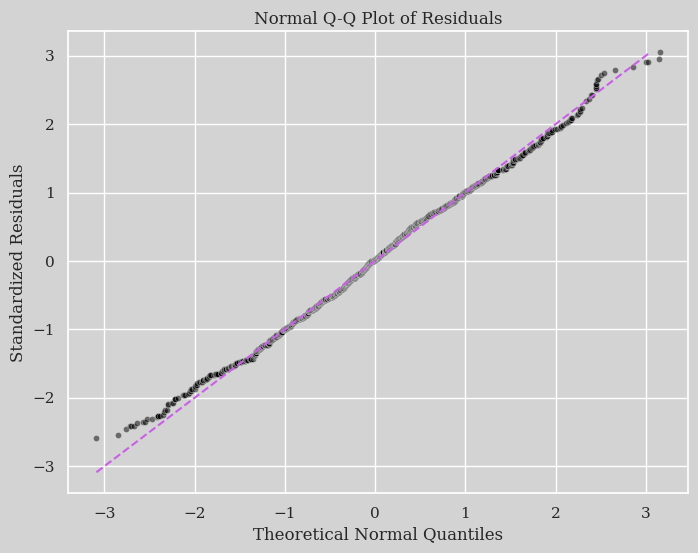

In [ ]:

fig, ax = plt.subplots(ncols=1, figsize=(8, 6))


sns.scatterplot(x=normal_theo,
                y=standardized_resid_sorted,
                color="black",
                ax=ax,
                alpha=0.5,
                s=20)

line_coords = np.linspace(min(normal_theo), max(standardized_resid_sorted))

ax.plot(line_coords, line_coords, color='#ca5fe8', linestyle="--") 


ax.set_title('Normal Q-Q Plot of Residuals')
ax.set_xlabel('Theoretical Normal Quantiles')
ax.set_ylabel('Standardized Residuals');


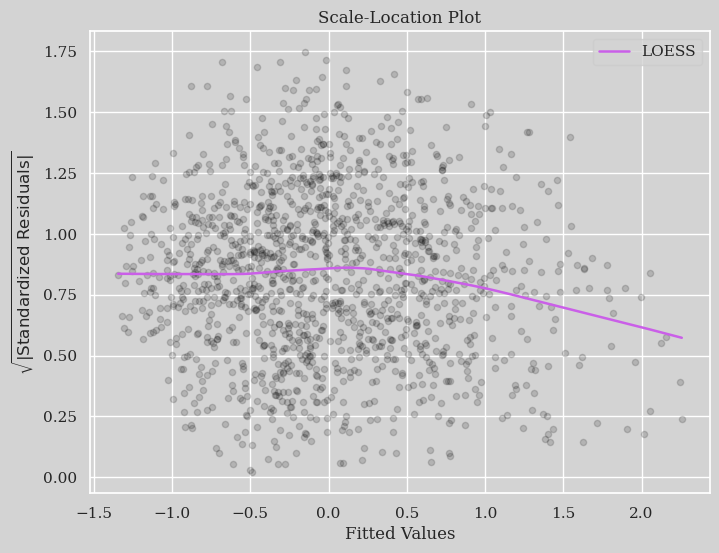

In [ ]:
abs_standardized_resid = np.abs(standardized_resid)
sqrt_abs_standardized_resid = np.sqrt(abs_standardized_resid)

fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
sns.regplot(x=model.predict(),
            y=sqrt_abs_standardized_resid,
            ax=ax,
            scatter_kws={'alpha': 0.15, 'color': 'black', 's': 20}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False    
           )

ax.set_title('Scale-Location Plot')
ax.set_xlabel('Fitted Values') 
ax.set_ylabel(r'$\sqrt{|\text{Standardized Residuals}|}$')

plt.legend()
plt.show()


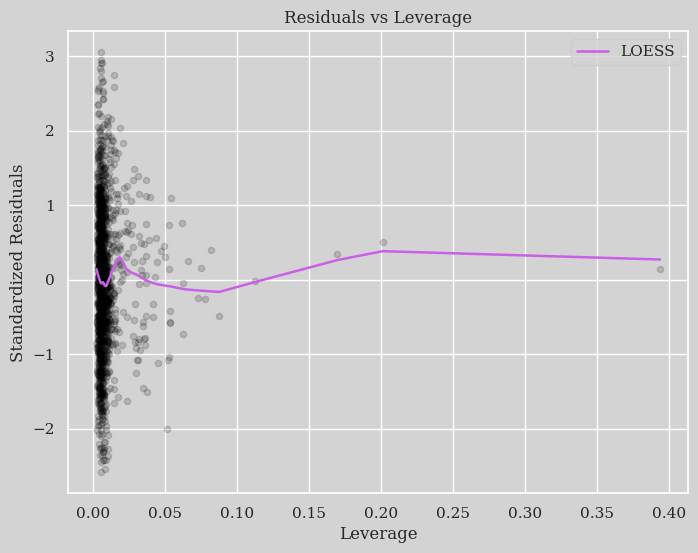

In [ ]:
influence = model.get_influence()
leverage_values = influence.hat_matrix_diag

scaler = StandardScaler()
scaler.fit(model.resid.to_frame())
standardized_resid = scaler.transform(model.resid.to_frame()).squeeze()

fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
sns.regplot(x=leverage_values,
            y=standardized_resid,
            ax=ax,
            scatter_kws={'alpha': 0.15, 'color': 'black', 's': 20}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False    
           )

ax.set_title('Residuals vs Leverage')
ax.set_ylabel('Standardized Residuals') 
ax.set_xlabel('Leverage')

plt.legend()
plt.show()

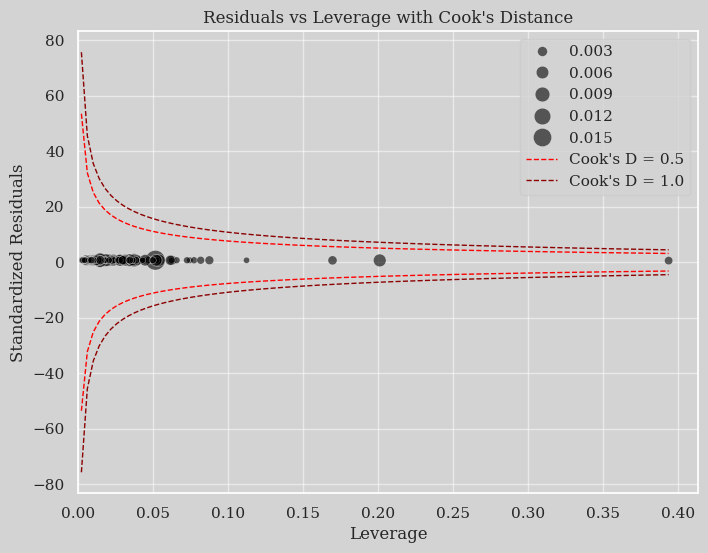

In [ ]:
influence = model.get_influence()

standardized_resid = influence.resid_std
leverage_values = influence.hat_matrix_diag
cooks_distance = influence.cooks_distance[0] 


fig, ax = plt.subplots(ncols=1, figsize=(8, 6))

sns.scatterplot(x=leverage_values,
                y=standardized_resid,
                size=cooks_distance,
                sizes=(20, 200),
                alpha=0.6,
                color='black',
                legend="brief", 
                ax=ax)


num_params = model.df_model + 1

leverage_plot = np.linspace(leverage_values.min(), leverage_values.max(), 100)
leverage_plot = leverage_plot[(leverage_plot > 0) & (leverage_plot < 1)]

def cooks_threshold_y(cooks_d, leverage, num_params):
    h_ii_safe = leverage + np.finfo(float).eps # to avoid division by 0

    one_minus_h_ii_safe = (1 - leverage) + np.finfo(float).eps
    
    numerator = cooks_d * num_params * one_minus_h_ii_safe
    denominator = h_ii_safe
    
    y_squared = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator!=0)
    y_squared[y_squared < 0] = 0 

    return np.sqrt(y_squared)

cooks_d_threshold1 = 0.5
cooks_d_threshold2 = 1.0

y_threshold1 = cooks_threshold_y(cooks_d_threshold1, leverage_plot, num_params)
y_threshold2 = cooks_threshold_y(cooks_d_threshold2, leverage_plot, num_params)

ax.plot(leverage_plot, y_threshold1, label=f"Cook's D = {cooks_d_threshold1}", color='red', linestyle='--', lw=1)
ax.plot(leverage_plot, -y_threshold1, color='red', linestyle='--', lw=1)
ax.plot(leverage_plot, y_threshold2, label=f"Cook's D = {cooks_d_threshold2}", color='darkred', linestyle='--', lw=1)
ax.plot(leverage_plot, -y_threshold2, color='darkred', linestyle='--', lw=1) 


ax.set_title("Residuals vs Leverage with Cook's Distance") 
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Leverage')
ax.set_xlim(left=0)

ax.legend()

plt.grid(True, linestyle='-', alpha=0.5)
plt.show()

Reference for cooks distance threshold: https://bookdown.org/colettemair0/bookdown/cooks-distance-and-leverage.html

**Cook's Distance contours** 

$r_i = \pm \sqrt{C \cdot p \cdot \frac{1 - h_{ii}}{h_{ii}}}$

Where: 
* $D_i$ - Cook's Distance 
* $r_i$ - studentized residual
* $h_{ii}$ - leverage value
* $p$ - number of parameters including intercept

---

### Evaluation

In [ ]:
df_test_clean, _ = wrangle(df_test, tranformers)

Test Mode
Test Mode


#### Baseline MAE using Mean

In [ ]:
def mae(y_true, y_pred):
    error = y_true - y_pred
    return abs(error).sum() / len(y_true)

In [ ]:
mean_chl = df_test_clean['chl_yeo'].mean()

mae(y_test, mean_chl)

0.8128567917156685

#### MAE using model train

In [ ]:
y_pred = model.predict(df_train_clean)

mae(df_train_clean['chl_yeo'], y_pred)

0.601986280735821

#### MAE using model test

In [ ]:
y_pred = model.predict(df_test_clean)

y_test = df_test_clean['chl_yeo']

mae(y_test, y_pred)

0.6108697843474106

### Orignal scale error

In [ ]:
# inversing yeo transformation to original scale
def revert_yeo(y : np.array, unscaled_colname : str, scaled_colname, tranformers : dict):
    y_frame = y.to_frame().rename({0: scaled_colname}, axis=1)

    y_scaled_copy = y_frame.copy().rename({scaled_colname : unscaled_colname}, axis=1)

    return tranformers[scaled_colname].inverse_transform(y_scaled_copy).squeeze()

#### Baseline

In [ ]:
y_mean = df_test_clean['chl'].mean()

mae(df_test_clean['chl'], y_mean)

3.0499895352416133

#### Model

In [ ]:
scaled_colname = "chl_yeo"
unscaled_colname = 'chl'

y_pred = model.predict(df_test_clean)

y_pred_unscaled =  revert_yeo(y_pred, unscaled_colname, scaled_colname, tranformers)

mae(df_test_clean['chl'], y_pred_unscaled)

2.207585377083036

## Communication

In [ ]:
list_params = model.params[1:].index.to_list()
results = []
r_sq = model.rsquared_adj

for param in list_params:
    temp_params = model.params[1:].index.to_list()
    temp_params.remove(param)
    
    formula = "chl_yeo ~ " + " + ".join(temp_params)

    model_tempt = ols(formula, data=df_train_clean)
    model_tempt = model_tempt.fit()

    string_to_remove = ", lower_bound=6.1706, upper_bound=8.0606"
    result_replace = param.replace(string_to_remove, "")

    result = {
            "predictor_wo" : result_replace,
            "RSS" : model_tempt.ssr,
            "RSE" : np.sqrt(model_tempt.scale),
            "Adj_RSq" : model_tempt.rsquared_adj,
            "difference_adj_rsq" : r_sq - model_tempt.rsquared_adj,
            "AIC" : model_tempt.aic,
            "BIC" : model_tempt.bic
        }
    
    results.append(result)

In [ ]:
df_com_importance = pd.DataFrame(results)
df_com_importance

,predictor_wo,RSS,RSE,Adj_RSq,difference_adj_rsq,AIC,BIC
0,dissolved_oxygen_yeo,786.564893,0.751705,0.435341,0.006770,3194.894281,3257.859248
1,"np.power(water_temp, 2)",790.844818,0.753748,0.432269,0.009842,3202.513136,3265.478103
2,"np.power(water_temp, 3)",790.093333,0.753390,0.432808,0.009303,3201.178378,3264.143345
3,"np.power(water_temp, 4)",789.239654,0.752982,0.433421,0.008690,3199.660566,3262.625533
4,"np.power(time_hour, 2)",855.667728,0.784031,0.385734,0.056377,3313.120775,3376.085742
5,"np.power(time_hour, 3)",873.761684,0.792277,0.372745,0.069367,3342.500224,3405.465191
6,"np.power(time_hour, 4)",877.772557,0.794093,0.369865,0.072246,3348.930329,3411.895296
7,"bs(ph, df=5)[0]",777.224864,0.747229,0.442046,0.000065,3178.122772,3241.087739
8,"bs(ph, df=5)[1]",778.924380,0.748046,0.440826,0.001285,3181.189472,3244.154439
9,"bs(ph, df=5)[2]",776.714221,0.746984,0.442413,-0.000302,3177.200030,3240.164997


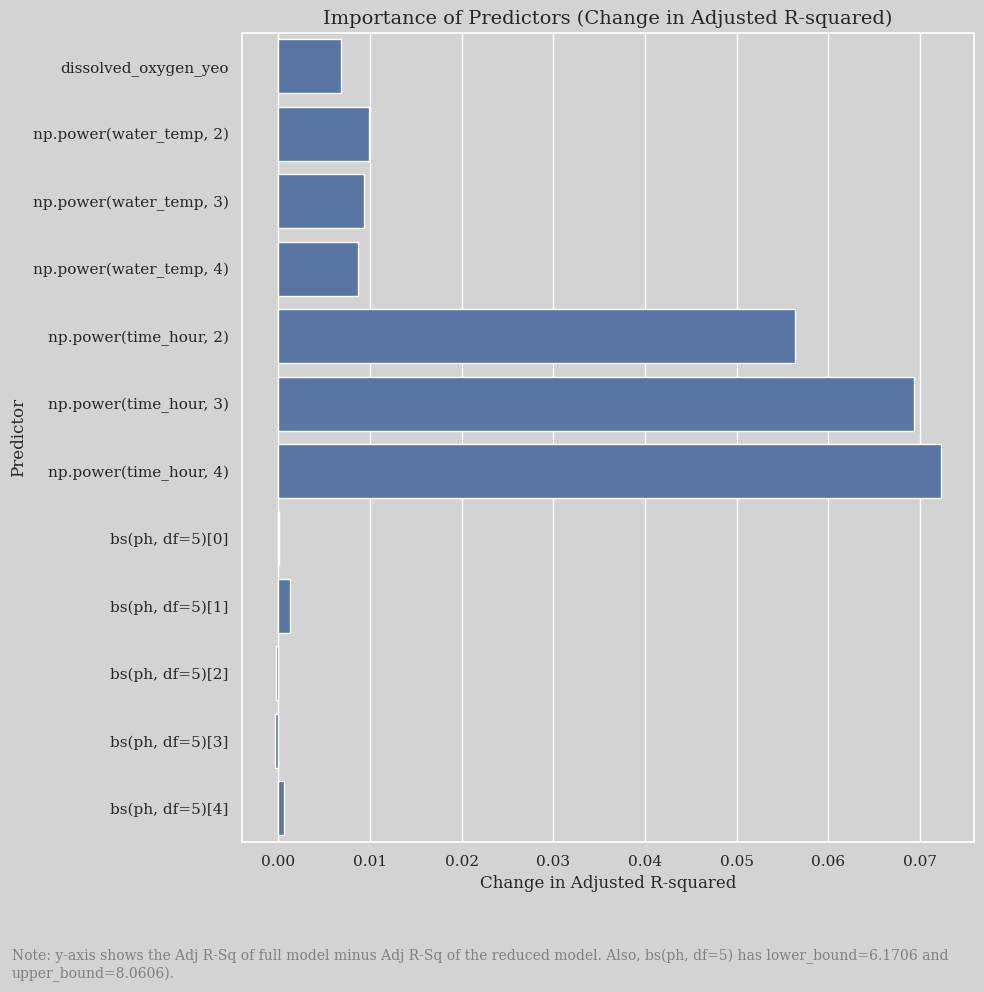

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(
    x=df_com_importance.difference_adj_rsq,
    y=df_com_importance.predictor_wo,
    ax=ax # Pass the axes object here
)

ax.set_xlabel('Change in Adjusted R-squared')
ax.set_ylabel('Predictor')
ax.set_title('Importance of Predictors (Change in Adjusted R-squared)', size=14)

note_text = "Note: y-axis shows the Adj R-Sq of full model minus Adj R-Sq of the reduced model. Also, bs(ph, df=5) has lower_bound=6.1706 and upper_bound=8.0606)."

fig.text(
    0.02,     
    0.01,       
    note_text, 
    wrap=True,  
    horizontalalignment='left',
    verticalalignment='bottom', 
    fontsize=10,
    color='gray' 
)

plt.tight_layout() 

plt.subplots_adjust(bottom=0.15)

plt.show()